In [1]:
pip install torch torchvision matplotlib opencv-python numpy

In [2]:
pip install --upgrade pillow

Using device: cuda
File: D:\saliency\db\train\image1000_jpg.rf.115e09ea49a3b389d32701ce27018231.jpg -- Final Detections: 0


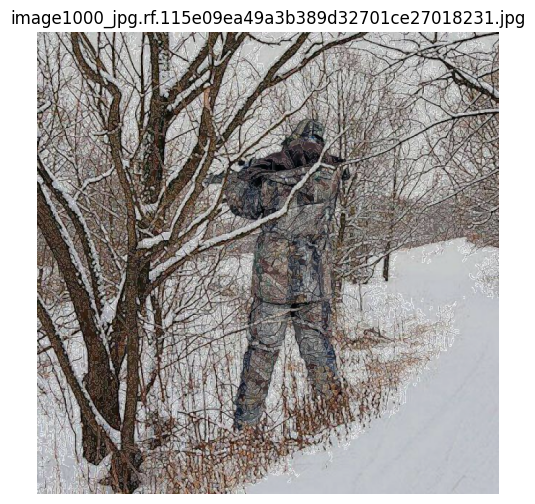

Saved output to D:\saliency\db\train\output\image1000_jpg.rf.115e09ea49a3b389d32701ce27018231.jpg
File: D:\saliency\db\train\image1000_jpg.rf.54de802cf1b7d0a6afe3c3aa391c7471.jpg -- Final Detections: 0


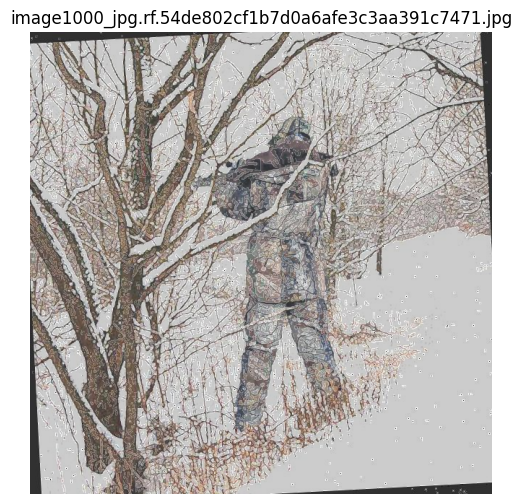

Saved output to D:\saliency\db\train\output\image1000_jpg.rf.54de802cf1b7d0a6afe3c3aa391c7471.jpg
File: D:\saliency\db\train\image1000_jpg.rf.edf0300f3960692beae9abb42f75a644.jpg -- Final Detections: 0


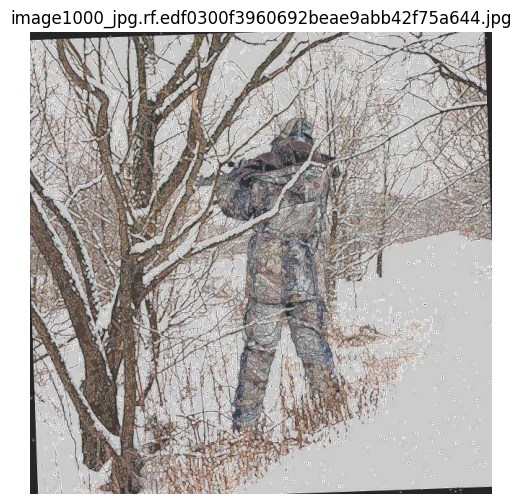

Saved output to D:\saliency\db\train\output\image1000_jpg.rf.edf0300f3960692beae9abb42f75a644.jpg
File: D:\saliency\db\train\image1001_jpg.rf.1abd4b574e0e9932a6cc3ae2465b6033.jpg -- Final Detections: 2


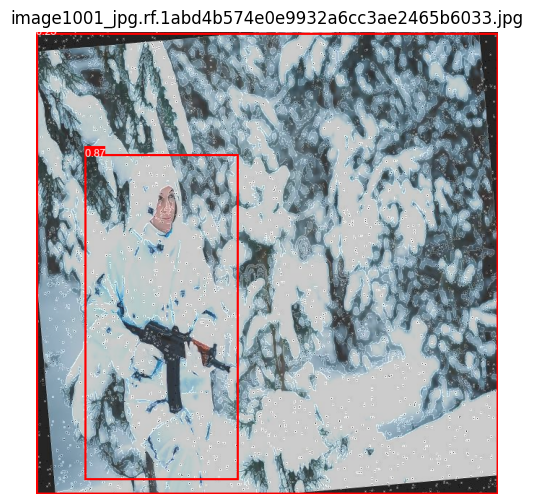

Saved output to D:\saliency\db\train\output\image1001_jpg.rf.1abd4b574e0e9932a6cc3ae2465b6033.jpg
File: D:\saliency\db\train\image1001_jpg.rf.63bde89212c33314a2a4f8abae4098bd.jpg -- Final Detections: 2


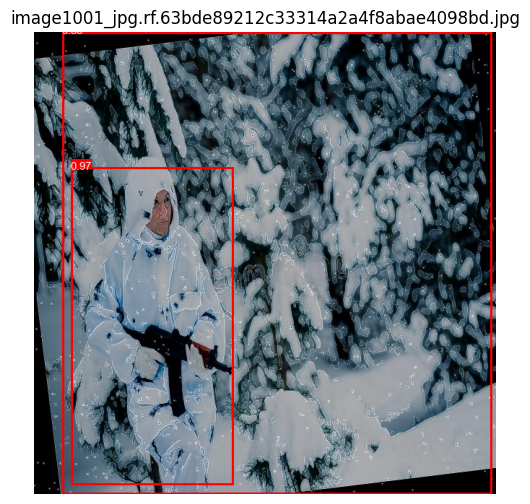

Saved output to D:\saliency\db\train\output\image1001_jpg.rf.63bde89212c33314a2a4f8abae4098bd.jpg
File: D:\saliency\db\train\image1001_jpg.rf.c8f4bc3a68e398758233314f90edc131.jpg -- Final Detections: 2


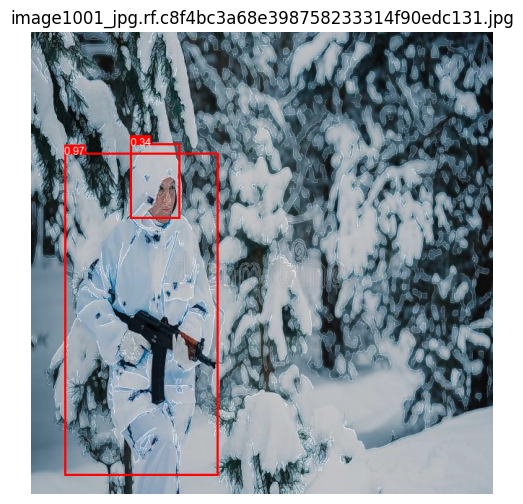

Saved output to D:\saliency\db\train\output\image1001_jpg.rf.c8f4bc3a68e398758233314f90edc131.jpg
File: D:\saliency\db\train\image1002_jpg.rf.80c6e4b17a5a35d8d9336aa8357cf9d2.jpg -- Final Detections: 6


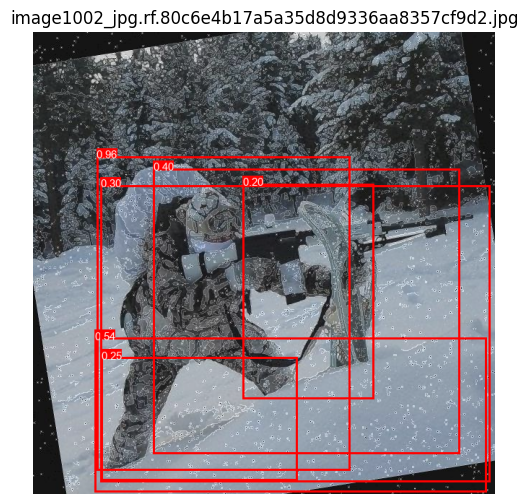

Saved output to D:\saliency\db\train\output\image1002_jpg.rf.80c6e4b17a5a35d8d9336aa8357cf9d2.jpg
File: D:\saliency\db\train\image1002_jpg.rf.87794ba347e2fab0b536d87eaf6fb303.jpg -- Final Detections: 1


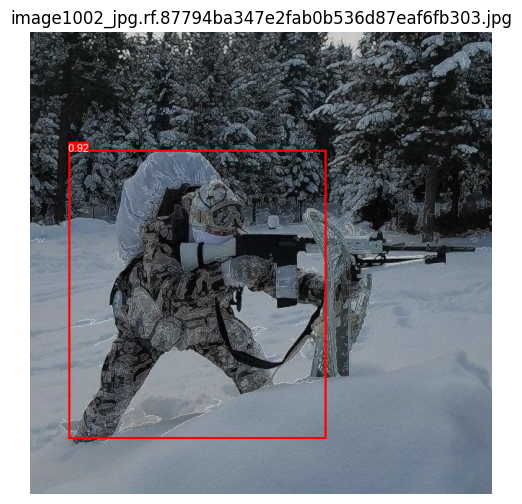

Saved output to D:\saliency\db\train\output\image1002_jpg.rf.87794ba347e2fab0b536d87eaf6fb303.jpg
File: D:\saliency\db\train\image1002_jpg.rf.89b8553bde9fe80d5fa189272e73b696.jpg -- Final Detections: 1


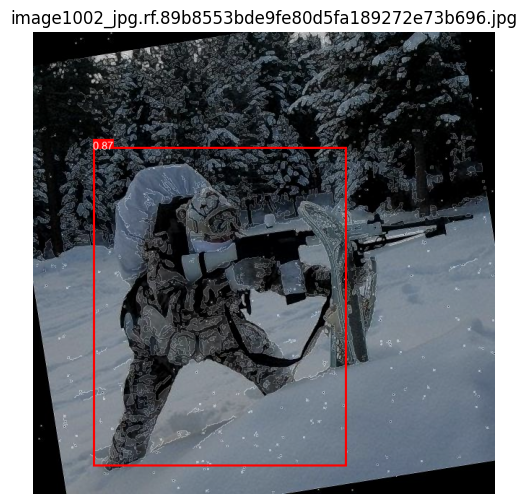

Saved output to D:\saliency\db\train\output\image1002_jpg.rf.89b8553bde9fe80d5fa189272e73b696.jpg
File: D:\saliency\db\train\image1003_jpg.rf.356aafaf06e3a88c1b0578003cf9b19b.jpg -- Final Detections: 1


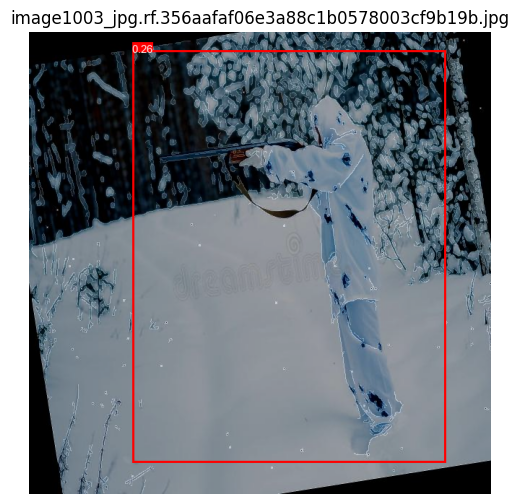

Saved output to D:\saliency\db\train\output\image1003_jpg.rf.356aafaf06e3a88c1b0578003cf9b19b.jpg
File: D:\saliency\db\train\image1003_jpg.rf.5db7300dd1236c6df0cef0d00b8eb49a.jpg -- Final Detections: 0
File: D:\saliency\db\train\image1003_jpg.rf.83089edee0a9457f7c36771bb4a25c6a.jpg -- Final Detections: 1
File: D:\saliency\db\train\image1004_jpg.rf.7225c3817b6bfc6cdb79a78f8c066a7e.jpg -- Final Detections: 0
File: D:\saliency\db\train\image1004_jpg.rf.9bada7da05ad8f807b2af7a16f719b5e.jpg -- Final Detections: 1
File: D:\saliency\db\train\image1004_jpg.rf.fc38553297817e28e6198336f8e826e6.jpg -- Final Detections: 1
File: D:\saliency\db\train\image1005_jpg.rf.843040ca3852278fabedb0b0f1ebe8c6.jpg -- Final Detections: 5
File: D:\saliency\db\train\image1005_jpg.rf.acf6561d4718e26ee62296739e44d8cc.jpg -- Final Detections: 1
File: D:\saliency\db\train\image1005_jpg.rf.af7ff7664b6717f9dfc23cb79a7531cc.jpg -- Final Detections: 3
File: D:\saliency\db\train\image1006_jpg.rf.82893a0acacda28ea39ceee0e1

In [ ]:
import os
import glob
import xml.etree.ElementTree as ET
import torch
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision import models, transforms
from torchvision.ops import nms
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# ------------------------------------------------------------------------------
# 1. Helper Functions
# ------------------------------------------------------------------------------
def parse_voc_annotation(xml_file):
    """
    Reads a VOC-style XML annotation file and returns:
      - A list of dicts: each dict has
        'name' -> class name (e.g., "Camo")
        'bbox' -> [xmin, ymin, xmax, ymax]
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall("object"):
        cls = obj.find("name").text.strip()
        bbox_xml = obj.find("bndbox")
        bbox = [
            float(bbox_xml.find("xmin").text),
            float(bbox_xml.find("ymin").text),
            float(bbox_xml.find("xmax").text),
            float(bbox_xml.find("ymax").text)
        ]
        objects.append({"name": cls, "bbox": bbox})
    return objects

def compute_iou(box1, box2):
    """
    Computes the Intersection over Union (IoU) of two bounding boxes.
    box format: [xmin, ymin, xmax, ymax]
    """
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    
    interW = max(0, xB - xA + 1)
    interH = max(0, yB - yA + 1)
    interArea = interW * interH

    box1Area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2Area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = interArea / float(box1Area + box2Area - interArea + 1e-6)
    return iou

def voc_ap(rec, prec):
    """
    Computes the Average Precision (AP) in a VOC-style manner:
    integrates over the precision-recall curve.
    """
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # Make precision monotonically decreasing
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = max(mpre[i - 1], mpre[i])

    # Identify points where recall changes
    i_list = np.where(mrec[1:] != mrec[:-1])[0]
    ap = 0.0
    for i in i_list:
        ap += (mrec[i + 1] - mrec[i]) * mpre[i + 1]
    return ap

# ------------------------------------------------------------------------------
# 2. Paths and Model Setup
# ------------------------------------------------------------------------------
dataset_path = r"D:\saliency\db\train"  # Change if needed
annotations_folder = os.path.join(dataset_path, "annotations")
output_path = os.path.join(dataset_path, "output")
os.makedirs(output_path, exist_ok=True)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained Faster R-CNN
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = models.detection.fasterrcnn_resnet50_fpn(weights=weights)
model.eval()
model.to(device)  # Move model to GPU if available

# Transformation for input images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# ------------------------------------------------------------------------------
# 3. Gather Image Files
# ------------------------------------------------------------------------------
image_extensions = ["*.jpg", "*.jpeg", "*.png"]
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(dataset_path, ext)))

if not image_files:
    print("No image files found in the dataset path.")
    exit()

# ------------------------------------------------------------------------------
# 4. Detection & Evaluation Settings
# ------------------------------------------------------------------------------
CONFIDENCE_THRESHOLD = 0.2   # minimum score to keep a detection
NMS_THRESHOLD = 0.7          # Non-Max Suppression threshold
MIN_OBJECT_SIZE = 50         # ignore small boxes
IOU_THRESHOLD = 0.5          # IoU >= 0.5 => True Positive

# ------------------------------------------------------------------------------
# 5. Data Structures for Storing Results
# ------------------------------------------------------------------------------
# all_annotations: { class_name: { image_id: [ {bbox, detected}, ... ] } }
all_annotations = defaultdict(lambda: defaultdict(list))

# all_detections: { class_name: [ {image_id, confidence, bbox}, ... ] }
all_detections = defaultdict(list)

# For global metrics (Precision, Recall, F1, etc.)
global_TP = 0
global_FP = 0
global_FN = 0

# ------------------------------------------------------------------------------
# 6. Run Inference & Collect Predictions
# ------------------------------------------------------------------------------
for i, img_file in enumerate(image_files):
    image_id = os.path.splitext(os.path.basename(img_file))[0]
    image = Image.open(img_file).convert("RGB")

    # --- Preprocessing: Edge detection to highlight camo (saliency approach) ---
    image_np = np.array(image)
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    image_np = cv2.addWeighted(image_np, 0.8, cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB), 0.2, 0)
    image = Image.fromarray(image_np)

    # --- Parse Ground Truth Annotations ---
    xml_path = os.path.join(annotations_folder, f"{image_id}.xml")
    if os.path.exists(xml_path):
        objects = parse_voc_annotation(xml_path)
        for obj in objects:
            cls_name = obj["name"]  # e.g., "Camo"
            bbox = obj["bbox"]
            all_annotations[cls_name][image_id].append({"bbox": bbox, "detected": False})
    else:
        print(f"[WARNING] No XML annotation found for {image_id}. Skipping evaluation for this image.")
        continue

    # --- Model Inference ---
    img_tensor = transform(image).unsqueeze(0).to(device)  # Move image to GPU if available
    with torch.no_grad():
        predictions = model(img_tensor)[0]

    scores = predictions["scores"].tolist()
    boxes = predictions["boxes"].tolist()

    # --- Filter by confidence and box size ---
    filtered_boxes = []
    filtered_scores = []
    for j in range(len(scores)):
        score = scores[j]
        box = boxes[j]
        width = box[2] - box[0]
        height = box[3] - box[1]
        if score >= CONFIDENCE_THRESHOLD and width > MIN_OBJECT_SIZE and height > MIN_OBJECT_SIZE:
            filtered_boxes.append(box)
            filtered_scores.append(score)

    # --- Apply Non-Max Suppression (NMS) ---
    if filtered_boxes:
        keep = nms(torch.tensor(filtered_boxes), torch.tensor(filtered_scores), NMS_THRESHOLD)
        filtered_boxes = [filtered_boxes[k] for k in keep]
        filtered_scores = [filtered_scores[k] for k in keep]

    print(f"File: {img_file} -- Final Detections: {len(filtered_boxes)}")

    # Visualization only for the first 10 images
    draw_image = Image.fromarray(image_np).copy()
    draw = ImageDraw.Draw(draw_image)
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    for box, score in zip(filtered_boxes, filtered_scores):
        all_detections["Camo"].append({
            "image_id": image_id,
            "confidence": score,
            "bbox": box
        })

        # Draw bounding box if we're displaying
        draw.rectangle(box, outline="red", width=3)
        text = f"{score:.2f}"
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_w = text_bbox[2] - text_bbox[0]
        text_h = text_bbox[3] - text_bbox[1]
        text_loc = (box[0], box[1] - text_h)
        draw.rectangle([text_loc, (box[0] + text_w, box[1])], fill="red")
        draw.text(text_loc, text, fill="white", font=font)

    if i < 10:
        # Show and save only the first 10 images
        plt.figure(figsize=(8, 6))
        plt.imshow(draw_image)
        plt.axis("off")
        plt.title(os.path.basename(img_file))
        plt.show()

        output_file = os.path.join(output_path, os.path.basename(img_file))
        draw_image.save(output_file)
        print(f"Saved output to {output_file}")
    else:
        # Skip display to reduce notebook output
        pass

# ------------------------------------------------------------------------------
# 7. Compute Average Precision (AP) and Global Metrics
# ------------------------------------------------------------------------------
aps = {}

for cls_name, detections in all_detections.items():
    # Sort detections by confidence (descending)
    detections = sorted(detections, key=lambda x: x["confidence"], reverse=True)

    TP_array = np.zeros(len(detections))
    FP_array = np.zeros(len(detections))

    # Count total ground truth boxes for this class
    total_gt = 0
    for img_id in all_annotations[cls_name]:
        total_gt += len(all_annotations[cls_name][img_id])

    # Evaluate each detection
    for i, det in enumerate(detections):
        image_id = det["image_id"]
        box_pred = det["bbox"]

        if image_id in all_annotations[cls_name]:
            max_iou = 0
            assigned_gt = None
            for gt in all_annotations[cls_name][image_id]:
                iou = compute_iou(box_pred, gt["bbox"])
                if iou > max_iou:
                    max_iou = iou
                    assigned_gt = gt
            
            if max_iou >= IOU_THRESHOLD and assigned_gt is not None:
                if not assigned_gt["detected"]:
                    TP_array[i] = 1
                    assigned_gt["detected"] = True
                else:
                    FP_array[i] = 1
            else:
                FP_array[i] = 1
        else:
            FP_array[i] = 1

    cum_TP = np.cumsum(TP_array)
    cum_FP = np.cumsum(FP_array)
    rec = cum_TP / (total_gt + 1e-6)
    prec = cum_TP / (cum_TP + cum_FP + 1e-6)

    ap = voc_ap(rec, prec)
    aps[cls_name] = ap
    print(f"AP for class '{cls_name}': {ap:.4f}")

    TP_class = int(cum_TP[-1])
    FP_class = int(cum_FP[-1])
    FN_class = total_gt - TP_class

    global_TP += TP_class
    global_FP += FP_class
    global_FN += FN_class

mAP = np.mean(list(aps.values())) if aps else 0.0
print(f"\nMean Average Precision (mAP): {mAP:.4f}")

# ------------------------------------------------------------------------------
# 8. Compute Global Precision, Recall, F1, and Accuracy
# ------------------------------------------------------------------------------
precision_global = global_TP / float(global_TP + global_FP + 1e-6)
recall_global = global_TP / float(global_TP + global_FN + 1e-6)
f1_global = 2.0 * (precision_global * recall_global) / (precision_global + recall_global + 1e-6)
accuracy_global = global_TP / float(global_TP + global_FP + global_FN + 1e-6)

print("\n===== Global Metrics (across all images) =====")
print(f"True Positives (TP): {global_TP}")
print(f"False Positives (FP): {global_FP}")
print(f"False Negatives (FN): {global_FN}")
print(f"Precision: {precision_global:.4f}")
print(f"Recall:    {recall_global:.4f}")
print(f"F1-score:  {f1_global:.4f}")
print(f"Accuracy:  {accuracy_global:.4f}")


In [1]:
import os
import random
import glob
import xml.etree.ElementTree as ET
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models.detection as detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

# ------------------------------------------------------------------------------
# 1. Dataset Class for CAMO Dataset (VOC Format)
# ------------------------------------------------------------------------------
class CamoDataset(Dataset):
    def __init__(self, img_dir, annot_dir, transform=None, train=True):
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        self.transform = transform

        # Load image file names
        self.image_files = []
        for ext in ["*.jpg", "*.jpeg", "*.png"]:
            self.image_files.extend(glob.glob(os.path.join(img_dir, ext)))

        # Use only 10% of dataset for training
        random.shuffle(self.image_files)
        num_samples = int(0.1 * len(self.image_files))  # 10% dataset
        self.image_files = self.image_files[:num_samples] if train else self.image_files[num_samples:]

    def __len__(self):
        return len(self.image_files)

    def parse_voc_annotation(self, xml_file):
        """ Parses a VOC-style XML annotation file. """
        tree = ET.parse(xml_file)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall("object"):
            name = obj.find("name").text.strip()
            bbox = obj.find("bndbox")
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assume "1" is the label for camo objects

        return {"boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64)}

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Get annotation path
        image_id = os.path.splitext(os.path.basename(img_path))[0]
        annot_path = os.path.join(self.annot_dir, f"{image_id}.xml")

        if os.path.exists(annot_path):
            target = self.parse_voc_annotation(annot_path)
        else:
            target = {"boxes": torch.empty((0, 4), dtype=torch.float32),
                      "labels": torch.empty((0,), dtype=torch.int64)}

        if self.transform:
            image = self.transform(image)

        return image, target


# ------------------------------------------------------------------------------
# 2. Load Dataset & Dataloader
# ------------------------------------------------------------------------------
dataset_path = r"D:\saliency\db\train"  # Change if needed
annotations_folder = os.path.join(dataset_path, "annotations")

# Image Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Train Loader (10% dataset)
train_dataset = CamoDataset(dataset_path, annotations_folder, transform=transform, train=True)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

print(f"Loaded {len(train_dataset)} training images.")

# ------------------------------------------------------------------------------
# 3. Load Pretrained Faster R-CNN Model & Modify
# ------------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Pretrained Model
model = detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")
num_classes = 2  # Background + Camo

# Modify Classifier Head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move Model to GPU (if available)
model.to(device)

# ------------------------------------------------------------------------------
# 4. Training Setup
# ------------------------------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

# ------------------------------------------------------------------------------
# 5. Training Loop
# ------------------------------------------------------------------------------
print("\nStarting training...\n")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

print("\nTraining Complete ✅")

# ------------------------------------------------------------------------------
# 6. Save Trained Model
# ------------------------------------------------------------------------------
model_save_path = "faster_rcnn_camo.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path} 🎯")


ValueError: num_samples should be a positive integer value, but got num_samples=0